# Calibration of models parameters: SPX
### based on One Touch Knock Out Daily Cliquet Options

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as scpo
import sys
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/functions')
sys.path.append('C:/Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules/calibration')
import time

pd.reset_option('all')

from BSpricer import BS_Pricer
from MERTONpricer import Merton_pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

np.random.seed(110)

Now we read the file containing historical SPX data of year 2016. We need to find the underlying value on Jan 20, 2016.

In [2]:
spx_data = pd.read_csv('../../data/SPX/SPX_data.csv')
print(spx_data.head(6))

         Date         Open         High          Low        Close      Volume
0  2016-01-20  1876.180054  1876.180054  1812.290039  1859.329956  6416070000
1  2016-01-21  1861.459961  1889.849976  1848.979980  1868.989990  5078810000
2  2016-01-22  1877.400024  1908.849976  1877.400024  1906.900024  4901760000
3  2016-01-25  1906.280029  1906.280029  1875.969971  1877.079956  4401380000
4  2016-01-26  1878.790039  1906.729980  1878.790039  1903.630005  4357940000
5  2016-01-27  1902.520020  1916.989990  1872.699951  1882.949951  4754040000


Let's retrieve the prices for One Touch Knock Out options on the SPX.

In [3]:
otko_spx = pd.read_csv('../../data/SPX/otko_prices_spx.csv')
print(f'Otko Prices: \n')
print(otko_spx.head())
SPX_S0 = spx_data.loc[spx_data['Date'] == '2016-01-20', 'Close'].values[0]
print(f'\n SPX Closing Value on 20/01/2016:', round(SPX_S0, 2))

Otko Prices: 

  Starting date Stock Name Expiry  K1  K2      BID      ASK
0    20/01/2016        SPX     6M  75   0  0.0850%  0.1000%
1    20/01/2016        SPX     6M  70   0  0.0400%  0.0500%
2    20/01/2016        SPX     6M  85  75  0.1700%  0.2000%
3    20/01/2016        SPX     6M  80  70  0.1200%  0.1400%
4    20/01/2016        SPX     6M  90  80  0.2400%  0.2700%

 SPX Closing Value on 20/01/2016: 1859.33


### Visualize payoffs of OTKO contracts

The BID(%) and ASK(%) prices are in percentages. This means that the protection buyer pays the $bid(%) * S0$ when acquiring the option, while the seller receives the $ask(%) * S0$.

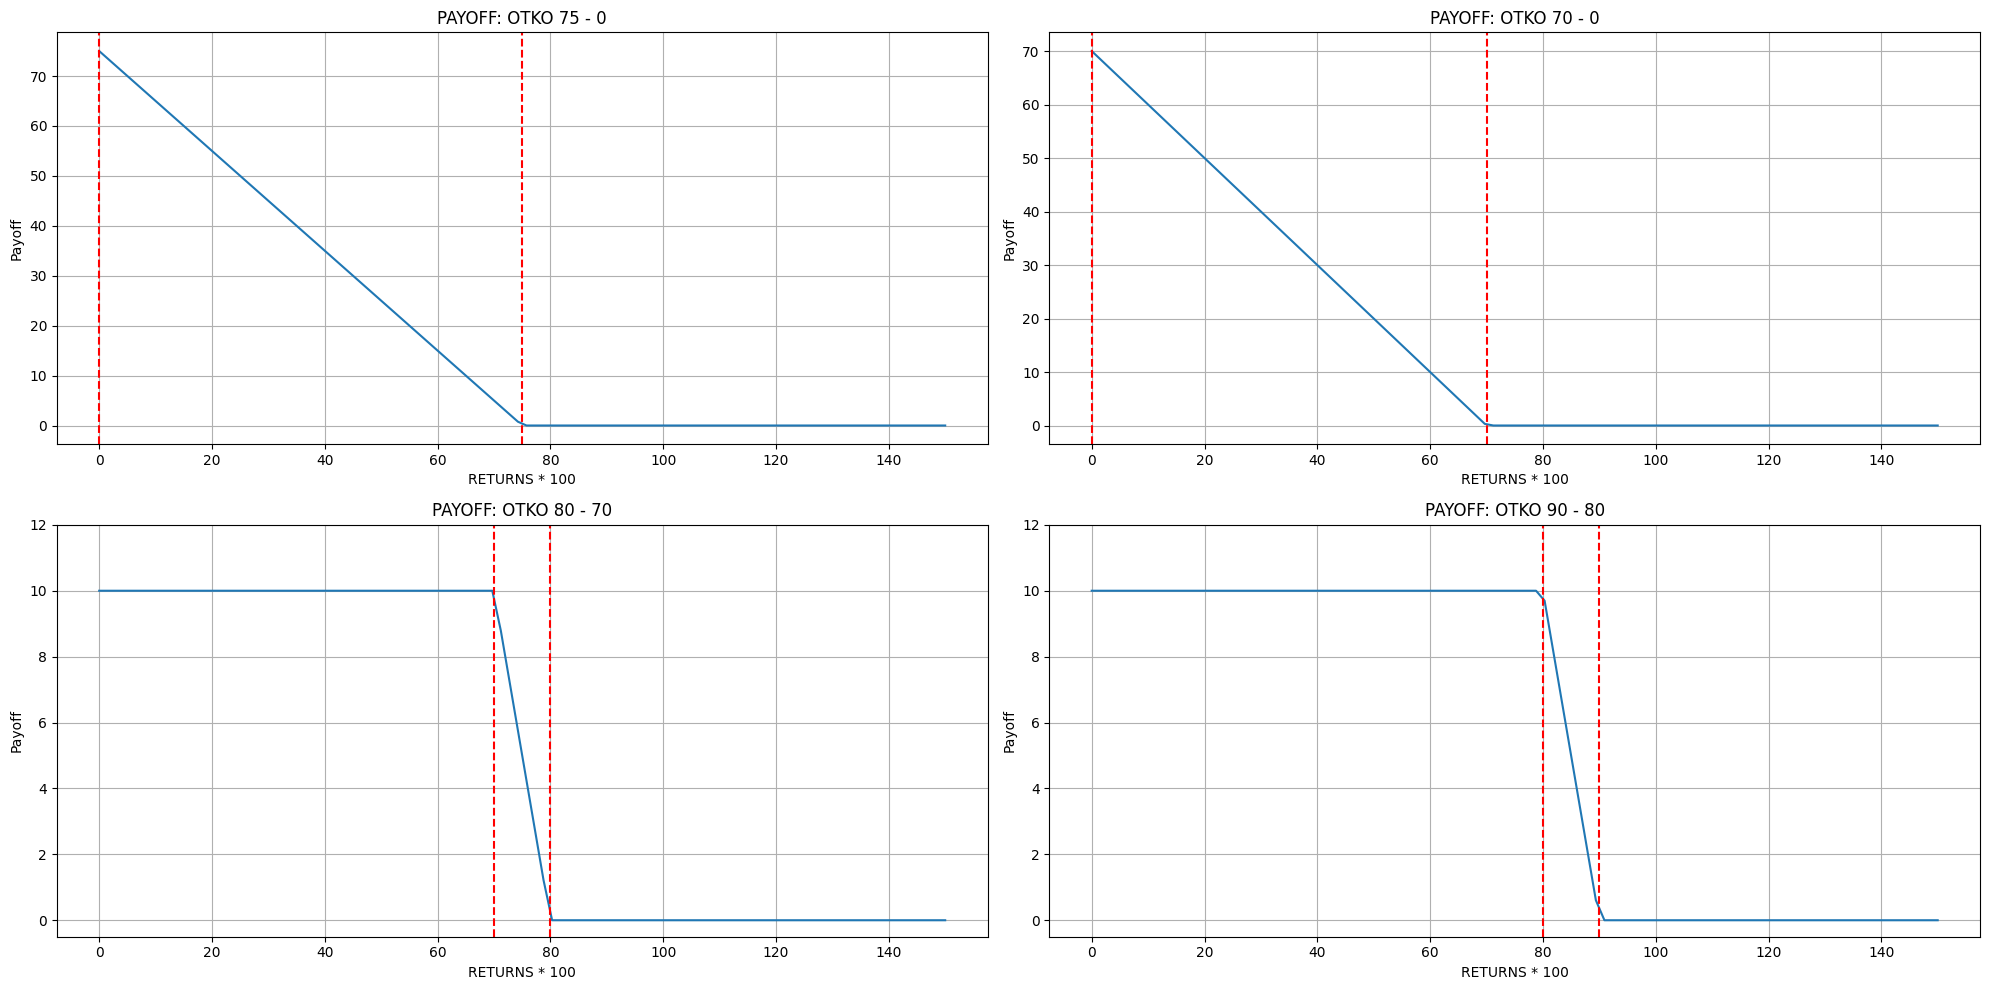

In [4]:
def otko_payoff(R, K1, K2):
    # R: Rendimento St/St-1 * 100
    # K2: Barriera di knock out
    # K1: Barriera di one touch
    # payoff_value: Valore del payoff quando l'opzione è attiva

    payoffs = []
    for Rt in R:
        if Rt > K1:
            payoffs.append(0)
        elif K2 < Rt <= K1:
            payoffs.append((K1 - Rt))
        elif Rt <= K2:
            payoffs.append((K1-K2))
    return payoffs

R = np.linspace(0,150,100)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
row = 0
col = 0

for index, contract in otko_spx.iterrows():
    if index != 2:  # Exclude the 2nd row (index 1)
        K1 = contract['K1']
        K2 = contract['K2']
        axes[row, col].plot(R, otko_payoff(R, K1, K2))
        axes[row, col].set_xlabel('RETURNS * 100')
        axes[row, col].set_ylabel('Payoff')
        axes[row, col].set_title(f'PAYOFF: OTKO {K1} - {K2}')
        if index != 0 and index!= 1:
            axes[row, col].set_ylim(-0.5, 12)
        axes[row, col].grid()
        # Add vertical lines for K1 and K2 (dashed)
        axes[row, col].axvline(x=K1, color='red', linestyle='--')
        axes[row, col].axvline(x=K2, color='red', linestyle='--')
        col += 1
        if col == 2:
            row += 1
            col = 0

plt.tight_layout()
plt.show()


#### Refactoring dataset

In [5]:
# Remove the percentage symbol and convert the columns to float
otko_spx['BID'] = otko_spx['BID'].str.rstrip('%').astype(float)
otko_spx['ASK'] = otko_spx['ASK'].str.rstrip('%').astype(float)

# Refactor to 1YEAR expiry
otko_spx['Expiry'] = '1Y'
otko_spx['BID'] = 2 * otko_spx['BID']
otko_spx['ASK'] = 2 * otko_spx['ASK']

# Rename the columns
otko_spx.rename(columns={'BID': 'BID(%)', 'ASK': 'ASK(%)'}, inplace=True)
midpoints = otko_spx['BID(%)'] + (abs(otko_spx['BID(%)'] - otko_spx['ASK(%)']) / 2)
otko_spx.insert(6, 'Midpoint(%)', midpoints)
print(otko_spx)

# otko_spx.to_csv('data/otko_spx_1year.csv', index=False)


  Starting date Stock Name Expiry  K1  K2  BID(%)  Midpoint(%)  ASK(%)
0    20/01/2016        SPX     1Y  75   0    0.17        0.185    0.20
1    20/01/2016        SPX     1Y  70   0    0.08        0.090    0.10
2    20/01/2016        SPX     1Y  85  75    0.34        0.370    0.40
3    20/01/2016        SPX     1Y  80  70    0.24        0.260    0.28
4    20/01/2016        SPX     1Y  90  80    0.48        0.510    0.54


## One Touch Knock Out daily Cliquets Option Pricing
Here we price **otko** options using specific sets of parameters. These parameters were calibrated on **european calls and puts** options prices. This way we show that these two types of derivatives can model very different behaviour of our underlying. In fact, vanilla options are not suitable for delineating large **jumps** in the underlying stocks, while otko daily cliquets price positively at **extreme changes** in the price of the underlying asset.

In [6]:
S0 = spx_data.loc[0, 'Close']
r = 0.03
T = 1
q = 0
exercise = 'european'
symbol = 'SPX'
paths = 10000
days = 252

th_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'Midpoint (%)': otko_spx['Midpoint(%)']
})

th_mc_prices = pd.DataFrame({})
th_cf_prices = pd.DataFrame({})

strikes = otko_spx[['K1', 'K2']].values / 100

### Black and Scholes Model

Black and Scholes SPX value after 252 days: 1914.1803855999972


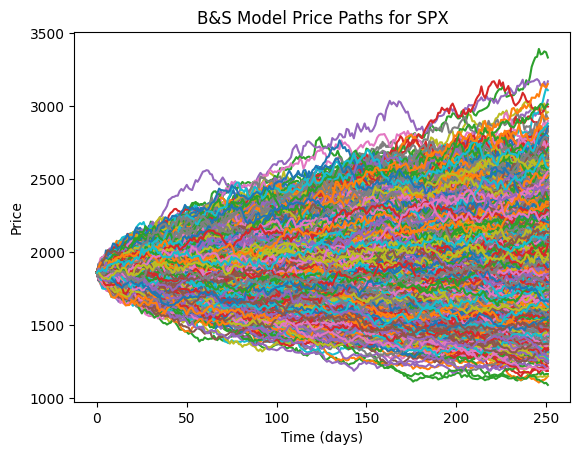

<Figure size 1000x600 with 0 Axes>

In [7]:
sigma = 0.13633  # vola from weighted calibration
BS = BS_Pricer(S0, r, q, sigma, T, exercise, None)
SBlackScholes = BS.BlackScholesPath(days, paths)
BS.plotBSPath(SBlackScholes, symbol)
avg_final_value = SBlackScholes[-1,:].mean()
print(f'Black and Scholes SPX value after 252 days: {avg_final_value}')

In [8]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SBlackScholes.T:
        payoffs.append(BS.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

bs_mc_prices = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    bs_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] *100

th_prices['B&S MC (%)'] = bs_mc_prices
print(th_prices)

   K1  K2  Midpoint (%)  B&S MC (%)
0  75   0         0.185         0.0
1  70   0         0.090         0.0
2  85  75         0.370         0.0
3  80  70         0.260         0.0
4  90  80         0.510         0.0


### Merton Model
Let's retrieve first the parameters calibrated with the plain vanilla option prices. They are used to find prices of the **One-Touch KnockOut Daily Cliquet** options, which serve as a benchmark for calibration.

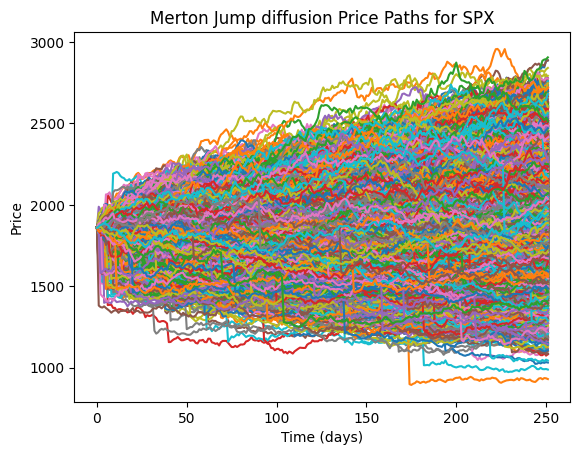

<Figure size 1000x600 with 0 Axes>

In [9]:
# calibrated params from plain vanilla options
#mert_params = [ 0.11156,  0.9275, -0.0795,  0.0848 ]
#mert_params = [0.0878, 0.9085, -0.118, 0.0963]
# mert_params = [0.085, 0.912, -0.1226, 0.0936]
#mert_params = [0.0898, 0.4648, -0.1864, 0.1384]         #calibrazione 6/8/23
#mert_params = [0.0879, 0.4824, -0.196, 0.1228]          # calibrazione 7/8/23
# mert_params = [0.1774, 1.1306, -0.13, 0.182]
# mert_params = [0.1205, 0.4862, -0.0381, 0.0481]     # calibrati il 16/8/23 (CALLS)
m_params_calls = [0.114, 0.4987, -0.0956, 0.0733]          # LAST GOOD CALIBRATION: 16/8/23 (CALLS)
m_params_puts = [0.1382, 0.6087, -0.0842, 0.357]

sigma, lambd, meanJ, stdJ = m_params_calls
MERT = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton = MERT.MertonPath(days, paths)
MERT.plotMertonPath(SMerton, symbol)  # Plot all paths


In [10]:
avg_final_value = SMerton[-1,:].mean()
print(f'Merton Jump Diffusion SPX value after 252 days: {avg_final_value}')

Merton Jump Diffusion SPX value after 252 days: 1919.0929305243499


In [11]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton.T:
        returns = path[1:] / path[:-1]
        payoffs.append(MERT.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(th_prices))

for index in range(len(th_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100

th_prices['MERTON MC (%)'] = merton_mc_prices
th_mc_prices['MERTON MC (%)'] = merton_mc_prices
# print(th_prices)


### Kou Jump Diffusion model

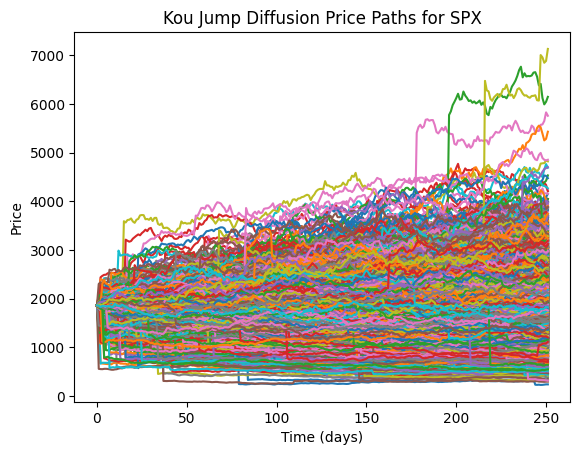

<Figure size 1000x600 with 0 Axes>

In [12]:
# calibrated params
# kou_params =[0.1233, 0.2608, 0.1961, 6.2507, 6.1967]
#kou_params = [0.07, 0.9296, 0.2498, 13.0534, 6.5574]
#kou_params = [0.0863, 1.2065, 0.4, 9.8519, 10.0]
#kou_params = [0.0932, 0.761, 0.2877, 1.5685, 1.2118]
#kou_params = [0.0932, 0.361, 0.2877, 5.5685, 4.2118]
# kou_params = [0.0976, 0.2195, 0.2574, 5.8654, 2.0341]
#kou_params = [0.0976, 0.2195, 0.2574, 2.8654, 4.0341]
# kou_params = [0.0888, 0.2883, 0.2506, 12.04, 2.3913]          # calibrazione 7/8/23
#kou_params = [0.0833, 0.9776, 0.3201, 5.2527, 4.2792]          # calibrati il 10/8/23  (PUTS)
#kou_params = [0.0358, 1.0469, 0.0942, 2.2675, 5.2646]          # calibrazione 16/10/23 (puts)
k_params_calls = [0.1192, 0.3314, 0.3675, 8.8496, 10.1685]         # LAST GOOD CALIBRATION: 16/8/23 (CALLS)
k_params_puts = [0.2193, 0.7222, 0.4273, 11.2726, 4.5653]          # LAST GOOD CALIBRATION: 16/8/23 (PUTS)

sigma, lambd, p, eta1, eta2 = k_params_puts
KOU = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, None)
SKou = KOU.KouPath(days, paths)
KOU.plotKouPath(SKou, symbol)  # Plot all paths

In [13]:
avg_final_value = SKou[-1,:].mean()
print(f'KOU Jump Diffusion SPX value after 252 days: {avg_final_value}')

KOU Jump Diffusion SPX value after 252 days: 1914.6372918817624


In [14]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou.T:
        payoffs.append(KOU.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100

th_prices['KOU MC (%)'] = kou_mc_prices
th_mc_prices['KOU MC (%)'] = kou_mc_prices
# print(th_prices)

### Variance Gamma Model

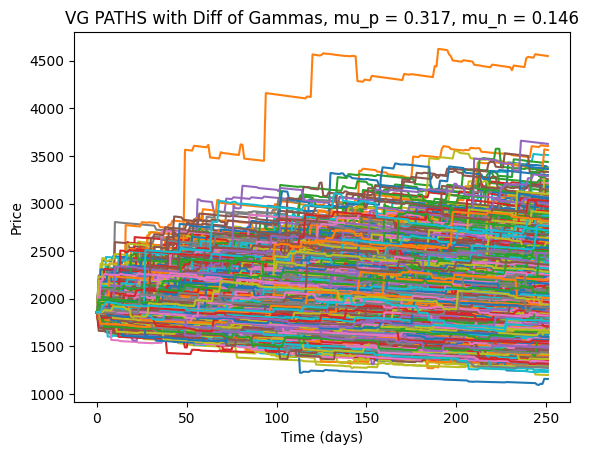

<Figure size 800x600 with 0 Axes>

In [15]:
# calibrated params
#vg_params = [0.1839, -0.0831, 0.9843]
#vg_params = [0.151, 0.0107, 0.0909]
#vg_params = [0.113, 0.1937, 0.3326]        #calibrati il 10/8/23 (CALLS)
#vg_params = [0.2765, 0.1725, 0.803]        # calibrati il 10/10/23 (PUTS)
#vg_params = [0.3285, 0.036, 1.7612]        # calibrazione 16/10/23
vg_params_calls = [0.1259, 0.1715, 0.1711]        # LAST GOOD CALIBRATION: 16/8/23 (CALLS)
vg_params_puts = [0.2962, 0.0778, 0.6548]        # LAST GOOD CALIBRATION: 16/8/23 (PUTS)


sigma, theta, nu = vg_params_calls
VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, None)
SVarGamma= VG.VarianceGammaPath2(days, paths)
VG.plotVGPath(SVarGamma, symbol, 'Diff of Gammas')  # Plot all paths

In [16]:
avg_final_value = SVarGamma[251,:].mean()
print(f'Variance Gamma SPX value after {days} days: {avg_final_value}')

Variance Gamma SPX value after 252 days: 1918.8444112664406


In [17]:
# Pass one by one path to the otko_payoff function. Returns an array of size (paths)
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma.T:
        payoffs.append(VG.payoff_otko(path,K1, K2))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(th_prices))
for index in range(len(th_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]*100

th_prices['VG MC (%)'] = vg_mc_prices
th_mc_prices['VG MC (%)'] = vg_mc_prices
# print(th_prices)

In [18]:
#pd.options.display.max_columns = 4
print(th_prices.iloc[:,:4])
print(th_mc_prices.to_string(index=False))

   K1  K2  Midpoint (%)  B&S MC (%)
0  75   0         0.185         0.0
1  70   0         0.090         0.0
2  85  75         0.370         0.0
3  80  70         0.260         0.0
4  90  80         0.510         0.0
 MERTON MC (%)  KOU MC (%)  VG MC (%)
      0.004571    1.367861   0.000000
      0.000389    0.956740   0.000000
      0.265100    1.277165   0.003185
      0.047387    0.987882   0.000577
      0.851295    1.631456   0.031205


### Monte Carlo vs Closed Forms prices
Let's now compare otko prices obtained by Monte carlo simulations with those obtained by closed form solutions.

#### Merton Jump Diffusion model

In [19]:
merton_prices_cf = np.zeros(len(th_prices))
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    merton_prices_cf[i] = MERT.closed_formula_otko(K1/100, K2/100)

th_prices['MERTON CF (%)'] = merton_prices_cf
th_cf_prices['MERTON CF (%)'] = merton_prices_cf
# print(th_prices)

#### Kou Jump diffusion model

In [20]:
kou_prices_cf = np.zeros(len(th_prices))
for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    kou_prices_cf[i] = KOU.closed_formula_otko(K1/100, K2/100)

th_prices['KOU CF (%)'] = kou_prices_cf
th_cf_prices['KOU CF (%)'] = kou_prices_cf
# print(th_prices)

#### Variance Gamma process

In [21]:
vg_prices_cf = np.zeros(len(th_prices))

for i, (K1, K2) in enumerate(zip(otko_spx['K1'].values, otko_spx['K2'].values)):
    vg_prices_cf[i] = VG.closed_formula_otko8(K1/100, K2/100)

th_prices['VG CF (%)'] = vg_prices_cf
th_cf_prices['VG CF (%)'] = vg_prices_cf
# print(th_prices)

In [22]:
print(th_prices.iloc[:, :4])
print('\n', th_mc_prices.to_string(index=False))
print('\n',th_cf_prices.to_string(index=False))

   K1  K2  Midpoint (%)  B&S MC (%)
0  75   0         0.185         0.0
1  70   0         0.090         0.0
2  85  75         0.370         0.0
3  80  70         0.260         0.0
4  90  80         0.510         0.0

  MERTON MC (%)  KOU MC (%)  VG MC (%)
      0.004571    1.367861   0.000000
      0.000389    0.956740   0.000000
      0.265100    1.277165   0.003185
      0.047387    0.987882   0.000577
      0.851295    1.631456   0.031205

  MERTON CF (%)  KOU CF (%)    VG CF (%)
      0.003622    1.224883 3.989075e-07
      0.000113    0.836600 1.931801e-08
      0.274179    1.227111 1.116589e-04
      0.045934    0.917518 7.056148e-06
      0.893366    1.612682 1.654046e-03


### Calibration of model parameters
The following code snippet perfoms calibration of the models parameters using closed forms.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i ^2},$$ $P_i$ are the market prices and $f$ is the pricing function, $f$ given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. The optimization problem is carried out using the module *least_squares* of the library `scipy.optimize`.
Let's define the spread first.

In [ ]:
# BOOK:  Financial modelling with jump processes  PAG 442
weights =  1/(otko_spx['ASK(%)'] - otko_spx['BID(%)'])**2
mkt_prices = otko_spx['Midpoint(%)'].values
print(weights)

0    1111.111111
1    2500.000000
2     277.777778
3     625.000000
4     277.777778
dtype: float64


#### Merton Jump Diffusion

In [24]:
#x0 = mert_params       # initial guess: [σ, λ, m, v]
x0 = [0.1336, 0.3, -0.5, 0.1]
bounds = ( [1e-3, 0, -2, 0], [2, 2, 0, 5] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = 0
    for k in range(len(strikes)):
        sq_err +=  weights[k]*(M.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k])**2
    return sq_err

start = time.time()
mert = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices), bounds=bounds, method = 'trf', verbose=1)
end = time.time()

mert_params_calibrated = [round(p,4) for p in mert.x[:4]]

The maximum number of function evaluations is exceeded.
Function evaluations 400, initial cost 5.1065e+08, final cost 9.9804e-04, first-order optimality 3.20e-03.


In [25]:
print('\nMETHOD: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params_calibrated[0]} \t {round(mert_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params_calibrated[1],2))
print('> Calibrated Jump Mean = ', round(mert_params_calibrated[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params_calibrated[3],3))
print(f'TIME ELAPSED:  {round(end-start,2)} sec')


METHOD: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.1336 	 13.36%
> Calibrated Jump intensity [λ] =  0.11
> Calibrated Jump Mean =  -0.165
> Calibrated Jump St. dev.  =  0.18
TIME ELAPSED:  1.22 sec


In [26]:
print(f'CALIBRATED PARAMETERS [σ\t\tλ\t\tm\t\tv]')
print(f'> European CALLS:\t {m_params_calls}')
print(f'> European PUTS:\t {m_params_puts}')
print(f'> OTKO DC:\t\t\t {mert_params_calibrated}')

CALIBRATED PARAMETERS [σ		λ		m		v]
> European CALLS:	 [0.114, 0.4987, -0.0956, 0.0733]
> European PUTS:	 [0.1382, 0.6087, -0.0842, 0.357]
> OTKO DC:			 [0.1336, 0.1054, -0.1649, 0.1803]


##### Visualize paths with the calibrated parameters

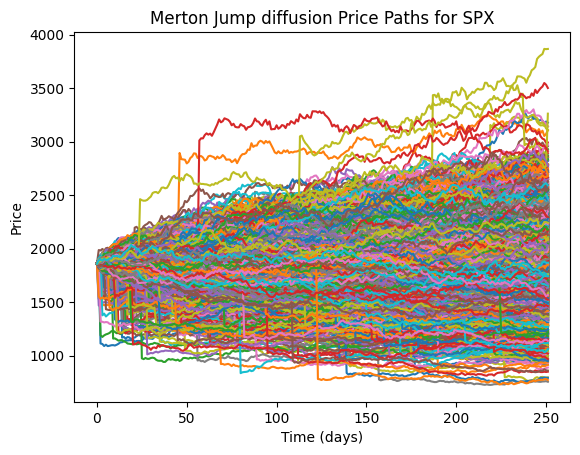

<Figure size 1000x600 with 0 Axes>

In [27]:
sigma_c, lambd_c, meanJ_c, stdJ_c = mert_params_calibrated
MERT_CAL = Merton_pricer(S0, None, T, r, q, sigma_c, lambd_c, meanJ_c, stdJ_c, exercise)
SMerton_CAL = MERT_CAL.MertonPath(days, paths)
MERT_CAL.plotMertonPath(SMerton_CAL, symbol)  # Plot all paths

#### Kou Jump diffusion model

In [28]:
#x0 = kou_params     # initial guess: [σ, λ, p, η_1, η_2]
x0 =[0.1247, 0.4346, 0.5228, 10.3, 7.5155]
#x0 =[0.15, 0.451, 9.0253]
#x0 = [0.23, 7.04, 0.015, 13.072, 24.155]
bounds = ( [1e-3, 1e-4, 0.001, 0, 0], [2, 10, 1,  20, 50] )
#bounds = ( [1e-4, 0.001, 0], [10, 1, 50] )


# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigma, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = 0
    for k in [0,1,2,3,4]:
        sq_err += weights[k]*(KOU.closed_formula_otko(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1, loss='soft_l1')
end2=time.time()

kou_params_calibrated = kou2.x[:5]

`ftol` termination condition is satisfied.
Function evaluations 87, initial cost 1.4580e+00, final cost 1.3317e+00, first-order optimality 2.06e-02.


In [29]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params_calibrated[0],4)} \t {round(kou_params_calibrated[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params_calibrated[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params_calibrated[2],2)}, [q] = {round(1-kou_params_calibrated[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params_calibrated[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params_calibrated[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.1247 	 12.47%
> Calibrated Jump intensity [λ] =  0.43
> Calibrated Upward Jump probability [p] = 0.53, [q] = 0.47
> Calibrated Rate of Exp. 1  [η_1] =  10.3
> Calibrated Rate of Exp. 2  [η_2] =  7.52
TIME ELAPSED:  0.03 sec


In [30]:
print(f'CALIBRATED PARAMETERS: [σ\t\tλ\t\tp\t\tη1\t\tη2]')
print(f'> European CALLS:\t {k_params_calls}')
print(f'> European PUTS:\t {k_params_puts}')
print(f'> OTKO DC:\t\t\t {[round(p,4) for p in kou_params_calibrated]}')

CALIBRATED PARAMETERS: [σ		λ		p		η1		η2]
> European CALLS:	 [0.1192, 0.3314, 0.3675, 8.8496, 10.1685]
> European PUTS:	 [0.2193, 0.7222, 0.4273, 11.2726, 4.5653]
> OTKO DC:			 [0.1247, 0.4313, 0.5324, 10.3, 7.5159]


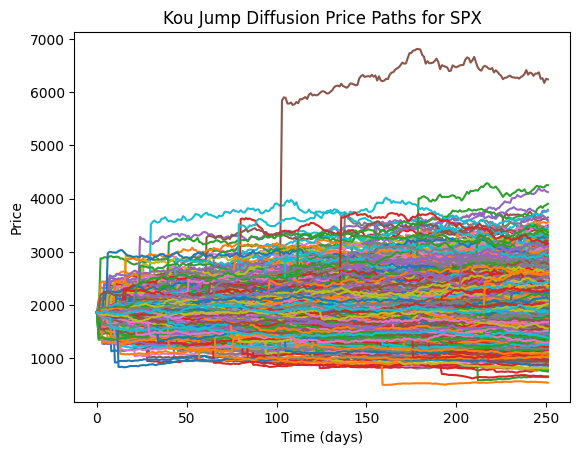

<Figure size 1000x600 with 0 Axes>

In [31]:
sigma, lambd, p, eta1, eta2 = kou_params_calibrated
KOU_CAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
#KOU = Kou_pricer(S0, None, T, r, 0.23, 7.04, 0.985,0.0765,0.0414, S0)

SKou_cal = KOU_CAL.KouPath(days, paths)
# Plot all paths
KOU_CAL.plotKouPath(SKou_cal, symbol)

#### Variance Gamma process model

In [32]:
x0 =[0.3034, 0.0675, 1.1941]  # initial guess: [σ, θ, v]
#x0 = vg_params
bounds = ( [1e-3, -5, 0], [0.6, 0.4, 4] )

def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    sq_err = 0
    for k in [0,1,2,3,4]:
        sq_err += weights[k]*(VG.closed_formula_otko8(strikes[k][0], strikes[k][1]) - mkt_prices[k]) ** 2
    return sq_err

start3=time.time()
vg = scpo.least_squares(cost_function, x0, args=(strikes, mkt_prices),  method='trf', bounds=bounds, verbose=1)
end3=time.time()

vg_params_calibrated = [round(p,4) for p in vg.x[:3]]

The maximum number of function evaluations is exceeded.
Function evaluations 300, initial cost 1.3856e+04, final cost 2.3504e+01, first-order optimality 7.92e+01.


In [33]:
print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params_calibrated[0]}, \t {round(vg_params_calibrated[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params_calibrated[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params_calibrated[2])
print(f'TIME ELAPSED:  {round(end3-start3,2)} sec')

METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.2566, 	 25.66%
> Calibrated mean rate gamma process [θ] =  0.078
> Calibrated variance rate gamma process [v]=  1.6178
TIME ELAPSED:  0.13 sec


In [34]:
print(f'CALIBRATED PARAMETERS: [σ \t\tθ\t\t v]')
print(f'> European CALLS:\t {vg_params_calls}')
print(f'> European PUTS:\t {vg_params_puts}')
print(f'> OTKO DC:\t\t\t {vg_params_calibrated}')

CALIBRATED PARAMETERS: [σ 		θ		 v]
> European CALLS:	 [0.1259, 0.1715, 0.1711]
> European PUTS:	 [0.2962, 0.0778, 0.6548]
> OTKO DC:			 [0.2566, 0.078, 1.6178]


VG as Time changed brownian Motion. Parameters: 
> Sigma = 0.2566
> Theta = 0.078
> Nu = 1.6178
VG as Difference of gammas. Parameters: 
> Mean Upward Jumps = 0.187
> Variance Upward Jumps = 0.057
> Mean Downward Jumps = 0.109
> Variance Downward Jumps = 0.019


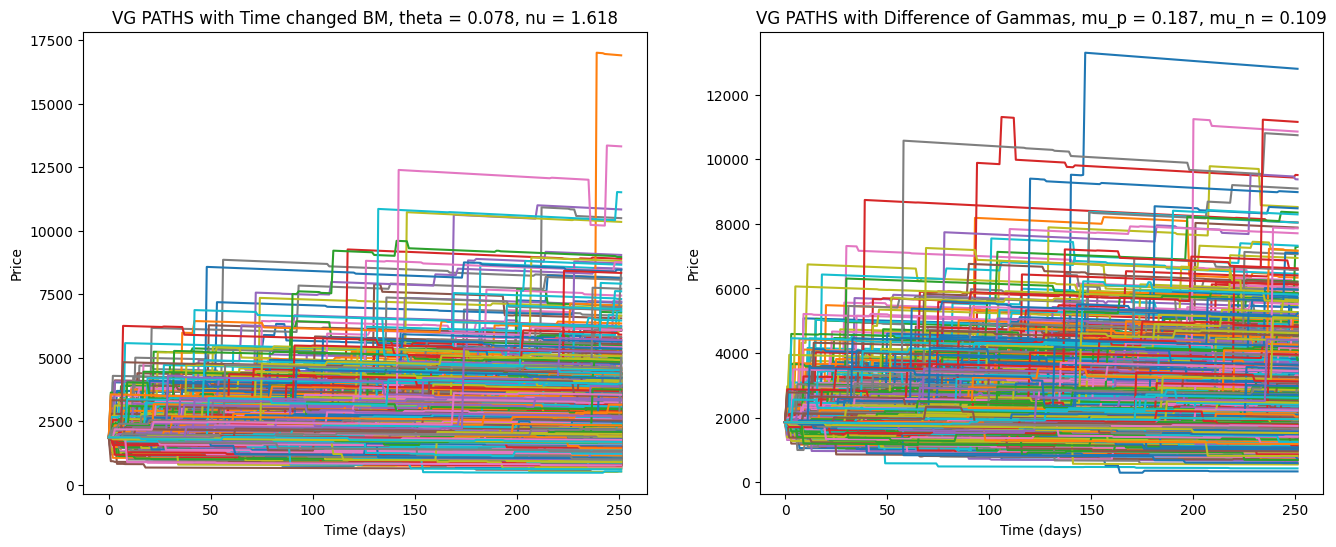

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [35]:
sigma, theta, nu = vg_params_calibrated

VG_CAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_cal = VG_CAL.VarianceGammaPath1(days, paths)
SVarGamma2_cal = VG_CAL.VarianceGammaPath2(days, paths)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
VG_CAL.plotVGPath(SVarGamma_cal, symbol, method[0], ax=axes[0])
VG_CAL.plotVGPath(SVarGamma2_cal, symbol, method[1], ax=axes[1])
plt.tight_layout()

print('VG as Time changed brownian Motion. Parameters: ')
print(f'> Sigma = {sigma}\n> Theta = {theta}\n> Nu = {nu}')
print('VG as Difference of gammas. Parameters: ')
print(f'> Mean Upward Jumps = {round(VG_CAL.get_mu_p,3)}\n> Variance Upward Jumps = {round(VG_CAL.get_nu_p,3)}')
print(f'> Mean Downward Jumps = {round(VG_CAL.get_mu_n,3)}\n> Variance Downward Jumps = {round(VG_CAL.get_nu_n,3)}')

### Option pricing with calibrated parameters
The following code snippet aims to find both Monte Carlo and Closed Formulas option prices for our **OTKO Daily Cliquet**.

In [36]:
calibrated_prices = pd.DataFrame({
    'K1': otko_spx['K1'],
    'K2': otko_spx['K2'],
    'MKT_BID (%)': otko_spx['BID(%)'],
    'MKT_MID (%)': otko_spx['Midpoint (%)'],
    'MKT_ASK (%)': otko_spx['ASK(%)']
})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{calibrated_prices}')

KeyError: 'Midpoint (%)'

#### Merton Jump diffusion

In [ ]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SMerton_CAL.T:
        payoffs.append(MERT_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(calibrated_prices))
merton_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    merton_cf_prices[index] = MERT_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['MERTON MC (%)'] = [round(p,2) for p in merton_mc_prices]
calibrated_prices['MERTON CF (%)'] = [round(p,2) for p in merton_cf_prices]



#### Kou Jump Diffusion

In [ ]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SKou_cal.T:
        payoffs.append(KOU_CAL.payoff_otko(path, K1, K2))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(calibrated_prices))
kou_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] * 100
    kou_cf_prices[index] = KOU_CAL.closed_formula_otko(strikes[index][0], strikes[index][1])

calibrated_prices['KOU MC (%)'] = [round(p,2) for p in kou_mc_prices]
calibrated_prices['KOU CF (%)'] = [round(p,2) for p in kou_cf_prices]

#### Variance Gamma

In [ ]:
avg_payoffs = []
for K1, K2 in strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for path in SVarGamma_cal.T:
        payoffs.append(VG_CAL.payoff_otko(path, K1, K2)/2)
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(calibrated_prices))
vg_cf_prices = np.zeros(len(calibrated_prices))

for index in range(len(calibrated_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index] *100
    vg_cf_prices[index] = VG_CAL.closed_formula_otko8(strikes[index][0], strikes[index][1])

calibrated_prices['VG MC (%)'] = [round(p,2) for p in vg_mc_prices]
calibrated_prices['VG CF (%)'] = [round(p,2) for p in vg_cf_prices]

In [ ]:
print(f'>> SPX OTKO OPTIONS REPRICED WITH CALIBRATED PARAMETERS\nMC = Monte Carlo pricing\nCF = Closed Formulas pricing\n')
print(calibrated_prices)